<a href="https://colab.research.google.com/github/azilberb/Zilberberg_BIX_F21/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project -

## Background

Foraging and the most efficient strategy for it is a constant issue for all animals, including humans.

At it's core foraging is the act of obtaining resources with a cost. These resources tangible or informational, and the cost could be resources or oppurtunity.

Examples-
1. A squirrel using energy (a resource cost) looking for acorns (a tangible resource) in trees.
2. A student reading an article online and gaining knowledge (an informational resource) for personal interest instead of studying for their final (an oppurtunity cost).

There is an important similarity between the two examples: the resources are found in patches. Acorns are in patches by trees, and often in further smaller patches on the trees. And information is in patches by media (articles or books for example). This "patching" can be generalized to almost all resources.

Furthermore it is important to note that the amount of new resource gained per unit of time will decrease as one forages in a patch. For our 2 examples: the less acorns there are in a tree the more difficult it is to find an acord, and the more you have already read an article the less there is to learn about the given topic.

This leads us to our problem that we will be discussing today-
What is the optimal time to spend in a patch and does the value of the resource effect this time?

The Marginal Value Theory, or MVT, claims that there is an algorithm that solves this issue: 
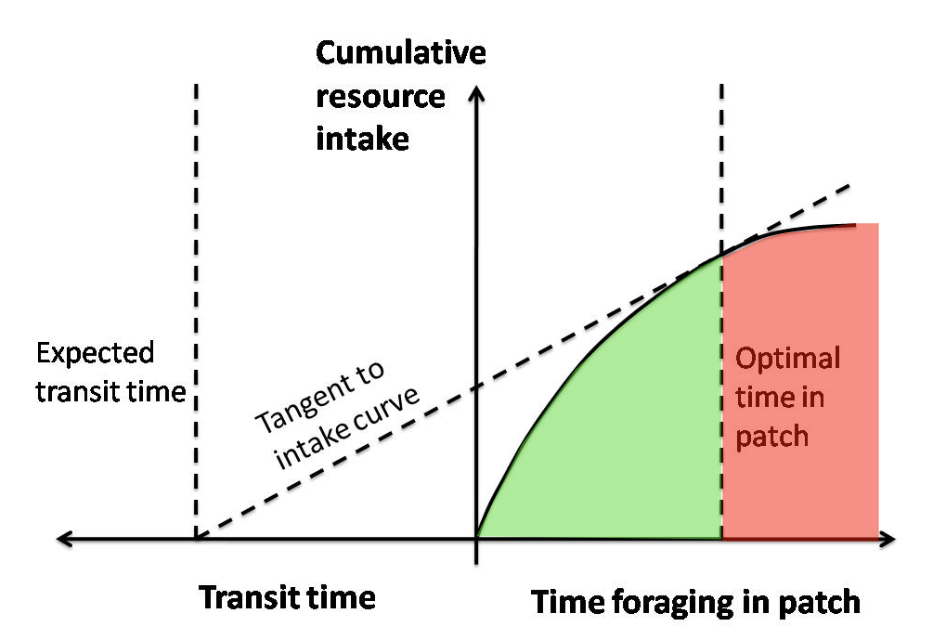

This graph shows that at the tangent point is the perfect time to switch patches in order to maximize reward.

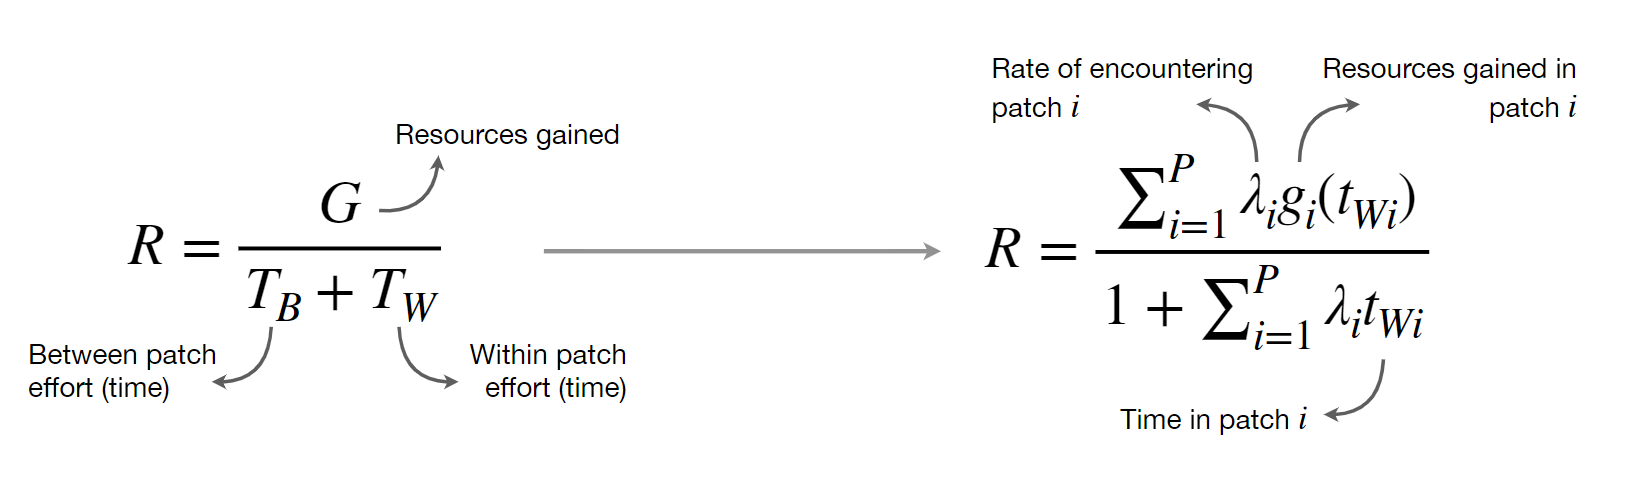

In addition MVT provides this equation where the goal for optimal reward is to maximize R by balancing G and T's well. 

# Problem/Goal:

There is no code I could find in epxloration lib that provides a patch enviroment so I will be making it myself.

After that we will need to make an agent that, simply put: will stay in a patch as long as it keeps finding targets within a certain set amount of time.

Testing this agent with different required reward times should let us tune it to an approximate optimal T(b).

Next we would randomly assign the patches reward values of 1 or 5. The goal now is to see how different the 2 required reward times after finding a 1 or 5 target will be in comparison to each other.

## Section - Setup

### Install ADMCode and explorationlib

In [7]:
# ADMCode uses an old version of numba
!pip install numba==0.48
!pip install --upgrade git+https://github.com/clappm/AdaptiveDecisionMaking_2018

  Cloning https://github.com/clappm/AdaptiveDecisionMaking_2018 to /tmp/pip-req-build-_kdr4rys
  Running command git clone -q https://github.com/clappm/AdaptiveDecisionMaking_2018 /tmp/pip-req-build-_kdr4rys


In [8]:
!pip install --upgrade git+https://github.com/azilberb/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

  Cloning https://github.com/azilberb/explorationlib to /tmp/pip-req-build-eev63et4
  Running command git clone -q https://github.com/azilberb/explorationlib /tmp/pip-req-build-eev63et4
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-2c186sbp
  Running command git clone -q https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-2c186sbp


### Import Modules

In [5]:
from __future__ import division
from ADMCode import visualize as vis
from ADMCode import ddm, sdt

import numpy as np
import pandas as pd

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [6]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientDiffusionDiscrete
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import TruncatedLevyDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import patch_targets
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death

/usr/local/lib/python3.7/dist-packages/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


pygame 2.1.0 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Notebook Config

In [9]:
# Pretty plots
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Testing an Agent on a Patch Enviroment:

## Creating a patch enviroment-
To create a patched enviroment I added a function in exploration lib that created a set number of random patches of a set size in a set field.

In [ ]:
#DO NOT RUN (only for show)
def patch_targets(N, shape, patch_max, prng=None):
    prng = _init_prng(prng)

    targets = []
    for s in shape:
        locs = prng.uniform(-s, s, size=N)
        coords = []
        print(locs)
        for loc in locs:
            patch_size = patch_max
            locs_patch = prng.uniform(loc-(patch_size), loc+(patch_size), size=patch_size)
            coords.extend(list(locs_patch))
        
        targets.append(deepcopy(coords))

    # Reorg into a list of location arrays
    targets = list(zip(*targets))
    targets = [np.asarray(t) for t in targets]

    return targets

Generating an Enviroment:

In [10]:
# Shared exp parameters
num_steps = 200
max_steps = 20
seed_value = 5838

min_length = 1
step_size = 0.1

noise_sigma = 2
detection_radius = 1
num_targets = 15 
target_boundary = (100, 100)
patch_max = 10

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)

# Targets
prng = np.random.RandomState(seed_value)
targets = patch_targets(num_targets, target_boundary, patch_max, prng=prng)
values = constant_values(targets, 1)

# Scents
coord, scent = create_grid_scent(target_boundary, amplitude=1, sigma=10)
scents = [scent for _ in range(len(targets))]
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

[ 57.18271902 -22.34090945 -85.51163698 -23.97968407 -15.88894459
 -10.90475617  74.45778756 -72.44736508  72.50912381  78.28162887
 -59.96333007 -81.79325031 -52.48055733  21.17331011  26.90945186]
[-30.79072558  73.61905696  53.6876727   77.77322802 -81.30411792
 -10.26690271  40.22657724   0.20310328  32.08907299  73.79721137
  76.46501519 -21.21367441 -16.56455473 -96.77345782  15.37308866]


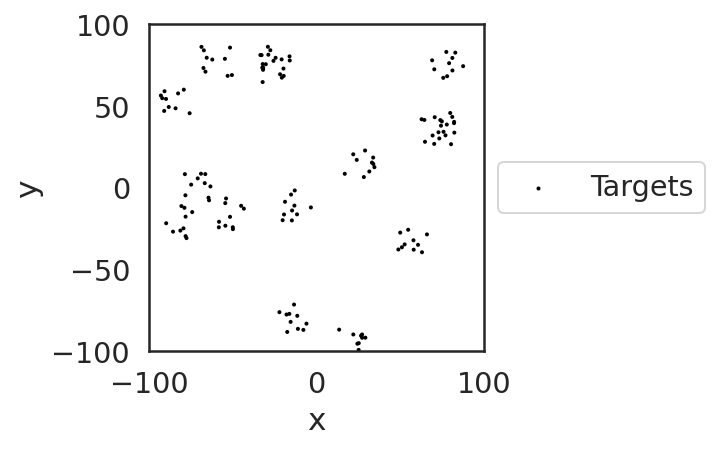

In [11]:
plot_boundary = (100, 100)
num_experiment = 0
ax = None

ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Run


In [13]:
# Our parameters 
drift_rates = [0.25, 0.75, 1.0, 1.25, 1.5]

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = drift_rates # list(range(5))

# Exp params
threshold = 3.0
accumulate_sigma = 1.0

num_experiments = 100

# Run
results = []
for i, drift_rate in zip(names, drift_rates):
    accum = AccumulatorGradientGrid(
        min_length=min_length, 
        max_steps=max_steps, 
        drift_rate=drift_rate, 
        threshold=threshold,
        accumulate_sigma=accumulate_sigma
    )
    accum.seed(seed_value)
    # !
    exp = experiment(
        f"accum_{i}",
        accum,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=True,
        seed=seed_value
    )
    results.append(exp)

accum_0:   0%|          | 0/100 [00:00<?, ?it/s]

accum_0:   0%|          | 0/100 [00:00<?, ?it/s]

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

### Plot an example

In [14]:
plot_boundary = (100, 100)
num_experiment = 0
ax = None
result = results
color = colors
ax = plot_position2d(
        select_exp(result, num_experiment),
        boundary=plot_boundary,
        label=i,
        color=color,
        alpha=1,
        ax=ax,
    )
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

TypeError: ignored

### Plot several metrics


In [ ]:
# Score
scores = []
for result in results:  
    l = 0.0
    for r in result:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

In [ ]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

In [ ]:
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

In [ ]:
# Score
scores = []
for result in results:  
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

## Conclusions:
I was not able to get my code to work in fine tuning the time spent in patch and so it is very hard to have definitive conclusions.

## Other notes since I did not have results: 
A paper by Summerside et al. called *Vigor of reaching movements: reward discounts the cost of effort* discusses how a higher anticipated reward essentially minimizes the cost of the effort required to get that reward. 

The example given at the very beginning of the paper states:

"Imagine you are sitting at your desk and the phone rings, but you do not recognize the number. You reach for the phone and answer to find it is an old friend. A few weeks later, the friend calls again, but this time you recognize the number. Again, you reach for the phone, excited to hear how they have been. Both scenarios require execution of a reaching movement. With the assumption that the physical constraints of reaching (i.e., initial arm configuration and end-point goal) are identical, will the reaching movements be the same? (Summerside 2018)"

This may seem unrelated since a change in movement doesn't mean you are more willing to put mroe effort, but a faster less accurate movement does actually take more energy.

Overall this paper concluded that even human movement seems to have an economic tendency with a higher effort made for a higher anticipated reward.